In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"

import tensorflow as tf
tf.enable_eager_execution()
tf.enable_v2_behavior()
sess = tf.InteractiveSession()
sess.as_default()

import util_funcs
from importlib import reload
import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import constants
import clinical_text_analysis as cta
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path
import predictSeizureConvExp as psce
import keras_models.dataGen as dg
from addict import Dict
reload(psce)
from keras.utils import multi_gpu_model
import keras.optimizers
import ensembleReader as er
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, log_loss
from functools import lru_cache

Using TensorFlow backend.


# edss analysis, pulling segments and seizure labels
how to generate the edss files, we have to run the generateCachedClean.py script.
Then run through below to generate proper indexDict files.

In [2]:
eds = er.EdfDatasetSegments(pre_cooldown=0, post_cooldown=0, sample_time=0, num_seconds=2, n_process=8)
train_label_files_segs = eds.get_train_split()

Starting 8 processes
retrieving: 0
Starting 8 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000
starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [ ]:
import pickle as pkl
@lru_cache(40)
def get_pickle_data(edf, start_seconds, split="train"):
    #to keep all pickles manageable, we split for every 500 into temporary files
    pickle_no = int(np.floor(start_seconds/1000)) + 1
    ref, patient, session, token = read.parse_edf_token_path_structure(edf)
    basePath = f"/n/scratch2/ms994/medium_size/{split}/{patient}/{session}/{token}/intermediate_{pickle_no}"
    return pkl.load(open(basePath, "rb"))
def get_data_from_start(edf, start_seconds, split="train"):
    data = get_pickle_data(edf, start_seconds, split)
    return data[start_seconds/2].data[:][0]

In [4]:
data = get_data_from_start(train_label_files_segs[0][0], 1000)

In [5]:
data[0].shape

(1000,)

In [35]:
train_label_files_segs[0][1].index.max()/pd.Timedelta(seconds=1)/2

650.0

In [170]:
train_split_preprocessed = "/n/scratch2/ms994/medium_size/train"
test_split_preprocessed = "/n/scratch2/ms994/medium_size/test"
valid_split_preprocessed = "/n/scratch2/ms994/medium_size/valid"

class FileDataReader(util_funcs.MultiProcessingDataset):
    def __init__(self, cachedIndex=None, split="train", directory=train_split_preprocessed, train_seg_files=None, overlap=2, unit_size=4, max_size=20):
        self.directory = directory
        self.overlap = overlap
        self.unit_size = unit_size
        self.train_seg_files = train_seg_files
        self.max_size = max_size
        self.split = split
        self.use_mp  = False
        if cachedIndex is None:
            self.indexDict = Dict() #used to grab and set the indexes used to grab data from the fs
            currentInd = 0
            for i in range(len(train_seg_files)):
                max_segment_index = train_label_files_segs[i][1].index.max()/pd.Timedelta(seconds=self.overlap)
                for j in range(int(np.floor(max_segment_index/self.max_size))):
                    startTime = j * self.max_size
                    self.indexDict[currentInd].start = startTime
                    self.indexDict[currentInd].edf_file = train_label_files_segs[i][0]

                    labelSlice = train_label_files_segs[i][1][ \
                                                              pd.Timedelta(seconds=startTime): \
                                                              pd.Timedelta(seconds=startTime)+pd.Timedelta(seconds=self.max_size) \
                                                             ]
                    self.indexDict[currentInd].label = not (labelSlice == "bckg").all()
                    self.indexDict[currentInd].time_seizure_label =  (labelSlice != "bckg")
                    self.indexDict[currentInd].time_seizure_subtypes = labelSlice.apply(lambda x: constants.SEIZURE_SUBTYPES.index(x))
                    currentInd+=1
        else:
            self.indexDict = cachedIndex
    def __len__(self):
        return len(self.indexDict)
    def  __getitem__(self, i):
        if self.should_use_mp(i):
            return self.getItemSlice(i)
        label = self.indexDict[i].time_seizure_label
        data = np.ndarray((11,21,1000))
        for j in range(11):
            data[j] = get_data_from_start(self.indexDict[i].edf_file, self.indexDict[i].start + j * 2, split=self.split)
        return data, label.values

In [173]:
class RULDataReader(util_funcs.MultiProcessingDataset):
    def __init__(self, cachedIndex=None, split="train"):
        self.indexDict = cachedIndex
        self.rebalance()
        self.use_mp = False
        self.split = split
    def rebalance(self):
        self.newIndexDict = Dict()
        oldIndicesByLabels = Dict()
        allLabels = Dict()
        for i in range(len(self.indexDict)):
            label = self.indexDict[i].label #use the first label
            if label not in oldIndicesByLabels.keys():
                oldIndicesByLabels[label] = []
                allLabels[label] = 0
            oldIndicesByLabels[label].append(i)
            allLabels[label] += 1

        min_label_count = min([allLabels[label] for label in allLabels.keys()])
        self.list_IDs = []
        for label in oldIndicesByLabels.keys():
            oldIndicesByLabels[label] = np.random.choice(oldIndicesByLabels[label], size=min_label_count, replace=False)
            for oldInd in oldIndicesByLabels[label]:
                self.list_IDs.append(oldInd)
        np.random.shuffle(self.list_IDs)
    def __len__(self):
        return len(self.list_IDs)
    def  __getitem__(self, i):
        if self.should_use_mp(i):
            return self.getItemSlice(i)
        new_i = self.list_IDs[i]
        label = self.indexDict[new_i].time_seizure_label
        data = np.ndarray((11,21,1000))
        for j in range(11):
            data[j] = get_data_from_start(self.indexDict[new_i].edf_file, self.indexDict[new_i].start + j * 2, split=self.split)
        return data, label.values

In [35]:
sessions = ["/n/scratch2/ms994/medium_size/test/" + directory for directory in  os.listdir("/n/scratch2/ms994/medium_size/test/")]

In [49]:
reload(util_funcs)

<module 'util_funcs' from '/home/ms994/dbmi_eeg_clustering/util_funcs.py'>

In [9]:
indexDict = pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb"))

In [87]:
read.parse_edf_token_path_structure(trainValidSess[0][0])

('01_tcp_ar', '00013182', 's001_2015_10_07', '00013182_s001_t000.edf')

In [88]:
read.parse_edf_token_path_structure(slicedIndices[0])

('medium_size', '00008453', 's007_2012_03_06', '00008453_s007_t011.edf')

In [11]:
slicedIndices = util_funcs.get_abs_files(util_funcs.get_abs_files(util_funcs.get_abs_files("/n/scratch2/ms994/medium_size/train/")), False)

In [42]:
trainValidPairs = eds.get_train_valid_split()

In [5]:
slicedIndices

'/n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf'

## apparently i forgot that train and valid sets are randomly made each time, edss doesn't match up exactly with first time script ran

In [13]:
newSliced = []
for slicedIndex in slicedIndices:
    split, patient, session, token = read.parse_edf_token_path_structure(slicedIndex)
    for pair in trainValidPairs:
        split, patient2, session2, token2 = read.parse_edf_token_path_structure(pair[0])
        if patient == patient2 and token == token2:
            newSliced.append(pair)

In [14]:
import preprocessingV2.preprocessingV2 as ppv2
reload(ppv2)
dr = ppv2.FileDataReader(split="train", directory="/n/scratch2/ms994/train", train_label_files_segs=newSliced)

In [15]:
pkl.dump(dr.indexDict, open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "wb"))

In [33]:
%%bash
ls /n/scratch2/ms994/medium_size/train

00000254
00000272
00000458
00000492
00000529
00000569
00000577
00000598
00000630
00000659
00000850
00000883
00000924
00001030
00001034
00001204
00001543
00001820
00001981
00002322
00002348
00002384
00002521
00002707
00002868
00002991
00003005
00003101
00003437
00004456
00005169
00005427
00005469
00005740
00005765
00005936
00006175
00006230
00006236
00006444
00006452
00006455
00006514
00006515
00006535
00006546
00006562
00006563
00006607
00006699
00006774
00006811
00006864
00006904
00007032
00007094
00007130
00007216
00007279
00007296
00007374
00007431
00007446
00007458
00007504
00007555
00007584
00007617
00007656
00007772
00007773
00007839
00007929
00007936
00007937
00008053
00008056
00008092
00008100
00008143
00008164
00008204
00008292
00008295
00008345
00008444
00008461
00008471
00008476
00008480
00008481
00008487
00008492
00008527
00008561
00008574
00008579
00008608
00008615
00008628
00008643
00008660
00008730
00008738
00008760
00008829
00008884
00008886
00008941
00008953
00008980
0

In [16]:
slicedIndices = util_funcs.get_abs_files(util_funcs.get_abs_files(util_funcs.get_abs_files("/n/scratch2/ms994/medium_size/valid/")), False)
newSliced = []
for slicedIndex in slicedIndices:
    split, patient, session, token = read.parse_edf_token_path_structure(slicedIndex)
    for pair in trainValidPairs:
        split, patient2, session2, token2 = read.parse_edf_token_path_structure(pair[0])
        if patient == patient2 and token == token2:
            newSliced.append(pair)

In [17]:
dr = ppv2.FileDataReader(split="valid", directory="/n/scratch2/ms994/valid", train_label_files_segs=newSliced)

In [18]:
pkl.dump(dr.indexDict, open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "wb"))

In [44]:
indexDict = pkl.load(open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "rb"))

In [47]:
len(indexDict.keys())

15594

In [4]:
import preprocessingV2.preprocessingV2 as ppv2
dr = ppv2.FileDataReader(split="test", directory="/n/scratch2/ms994/medium_size/test", cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb")))

In [38]:
pkl.dump(dr.indexDict,  open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "wb"))

In [7]:
reload(ppv2)
edg = dg.EdfDataGenerator(dr, precache=False, batch_size=4)
edg[0][0].shape

(4, 11, 21, 1000, 1)

In [ ]:
edg[0]

In [84]:
def getFnAnn(tknFn):
                labelFile = read.read_tse_file(tknFn + "/label.tse")
                ann = er.generate_label_rolling_window(labelFile, pre_cooldown=0, post_cooldown=0,sample_time=0, num_seconds=2)
                return tknFn, ann

In [ ]:
pkl.dump(dr.indexDict, open(dr.directory + "/20sindex.pkl", "wb"))

In [71]:
slicedIndices[0]

'/n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf'

In [72]:
%%bash 
ls /n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf

intermediate_1
label.tse
montage.lbl
notes.txt


In [76]:
labelFile = read.read_tse_file("/n/scratch2/ms994/medium_size/test/00008453/s007_2012_03_06/00008453_s007_t011.edf/label.tse")

In [78]:
import ensembleReader as er
ann = er.generate_label_rolling_window(labelFile, pre_cooldown=0, post_cooldown=0,sample_time=0, num_seconds=2)

In [29]:
edg = dg.EdfDataGenerator(rdr, precache=False, batch_size=32)

In [52]:
trainValidSess = eds.get_train_valid_split()

In [62]:
trainValidSessFN = [pair[0] for pair in trainValidSess].index("/home/ms994/v1.5.0/edf/" + ind) for ind in slicedIndices]

In [70]:
slicedIndices[0][30:]

'test/00008453/s007_2012_03_06/00008453_s007_t011.edf'

In [63]:
trainValidSessFN[0]

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf'

In [63]:
pkl.dump(dataReader.indexDict, open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "wb"))

In [69]:
len(pkl.load( open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb")))

35390

In [64]:
validDataReader = FileDataReader(train_seg_files=eds.get_valid_split())

starting custom_annotater
Starting 20 processes
retrieving: 0


In [70]:
pkl.dump(validDataReader.indexDict, open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "wb"))

In [ ]:
pkl.dump(testDataReader.indexDict, open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "wb"))

In [ ]:
testDataReader = FileDataReader(cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb")), split="test")

## Go through and separate indexDict into seizure and nonseizure classes for the train set only based on 20s indexDict to make reads faster.

In [3]:
trainIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb"))

In [4]:
labels = [trainIndexDict[i].label for i in range(len(trainIndexDict))]

In [5]:
sum(labels)/len(labels)

0.06799206537186167

In [6]:
from pathlib import Path

In [8]:
Path("/n/scratch2/ms994/medium_size/train/seizure_only").mkdir(parents=True, exist_ok=True)
Path("/n/scratch2/ms994/medium_size/train/non_seizure_only").mkdir(parents=True, exist_ok=True)

In [9]:
seizureIndices = []
nonSeizureIndices = []
for i in range(len(trainIndexDict)):
    if trainIndexDict[i].label:
        seizureIndices.append(trainIndexDict[i])
    else:
        nonSeizureIndices.append(trainIndexDict[i])

In [10]:
np.random.shuffle(seizureIndices)
np.random.shuffle(nonSeizureIndices)

In [22]:
from preprocessingV2 import preprocessingV2 as ppv2
# import util_funcs
# reload(ppv2)

In [23]:
for i in range(len(seizureIndices)):
    currIndex = seizureIndices[i]
    seizureIndices[i].old_ref_fn = ppv2.get_edf_pickle_name(currIndex.edf_file, currIndex.start, "train")
    seizureIndices[i].oldStart = seizureIndices[i].start
    del seizureIndices[i]["start"]
for i in range(len(nonSeizureIndices)):
    currIndex = nonSeizureIndices[i]
    nonSeizureIndices[i].old_ref_fn = ppv2.get_edf_pickle_name(currIndex.edf_file, currIndex.start, "train")
    nonSeizureIndices[i].oldStart = nonSeizureIndices[i].start
    del nonSeizureIndices[i]["start"]

In [62]:
seizureIndexDict = Dict()
nonSeizureIndexDict = Dict()

In [63]:
for i in range(len(seizureIndices)):
    seizureIndexDict[i] = seizureIndices[i]
    seizureIndexDict[i].start_sec = seizureIndexDict[i].oldStart 
    seizureIndexDict[i].end_sec = seizureIndexDict[i].oldStart  + 20
    seizureIndexDict[i].new_class_path = "/n/scratch2/ms994/medium_size/train/seizure_only/data_{}".format(int(np.ceil(i/500)))
for i in range(len(nonSeizureIndices)):
    nonSeizureIndexDict[i] = nonSeizureIndices[i]
    nonSeizureIndexDict[i].start_sec = nonSeizureIndexDict[i].oldStart 
    nonSeizureIndexDict[i].end_sec = nonSeizureIndexDict[i].oldStart + 20
    nonSeizureIndexDict[i].new_class_path = "/n/scratch2/ms994/medium_size/train/non_seizure_only/data_{}".format(int(np.ceil(i/500)))

In [6]:
from joblib import Parallel, delayed

In [65]:
seizureIndexDict[0]

{'edf_file': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/129/00012941/s002_2015_04_19/00012941_s002_t000.edf',
 'label': True,
 'time_seizure_label': 00:02:40    True
 00:02:42    True
 00:02:44    True
 00:02:46    True
 00:02:48    True
 00:02:50    True
 00:02:52    True
 00:02:54    True
 00:02:56    True
 00:02:58    True
 00:03:00    True
 Freq: 2S, dtype: bool,
 'time_seizure_subtypes': 00:02:40    2
 00:02:42    2
 00:02:44    2
 00:02:46    2
 00:02:48    2
 00:02:50    2
 00:02:52    2
 00:02:54    2
 00:02:56    2
 00:02:58    2
 00:03:00    2
 Freq: 2S, dtype: int64,
 'old_ref_fn': '/n/scratch2/ms994/medium_size/train/00012941/s002_2015_04_19/00012941_s002_t000.edf/intermediate_1',
 'oldStart': 160,
 'new_class_only': '/n/scratch2/ms994/medium_size/train/seizure_only/data_0',
 'start_sec': 160,
 'end_sec': 180,
 'new_class_path': '/n/scratch2/ms994/medium_size/train/seizure_only/data_0'}

In [73]:
singleClassIndexDict[0].new_class_path

'/n/scratch2/ms994/medium_size/train/seizure_only/data_0'

In [74]:
%%bash
ls /n/scratch2/ms994/medium_size/train/seizure_only/

data_1


In [ ]:
len(seizureIndex)

In [60]:
i = 0
singleClassIndexDict = seizureIndexDict
data = ppv2.get_data_from_start(edf=singleClassIndexDict[i].edf_file, start_seconds=int(singleClassIndexDict[i].start_sec), split="train")

In [61]:
data.shape

(21, 1000)

In [56]:
data[80]

{'index': 80,
 'data': <RawEDF  |  00012941_s002_t000.edf, n_channels x n_times : 21 x 1000 (4.0 sec), ~226 kB, data loaded>,
 'start': 160,
 'end': 164}

In [82]:
pkl.dump(seizureIndexDict, open("/n/scratch2/ms994/medium_size/train/seizure_only/indexDict.pkl", "wb"))
pkl.dump(nonSeizureIndexDict, open("/n/scratch2/ms994/medium_size/train/non_seizure_only/indexDict.pkl", "wb"))

In [7]:
seizureIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/seizure_only/indexDict.pkl", "rb"))
nonSeizureIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/non_seizure_only/indexDict.pkl", "rb"))

In [21]:
def writeSingleClassOnlyIndices(singleClassIndexDict, index):
    with open("out.out", "a") as writer:
        writer.write(f"running {index}\n")
    try:
        start = 500 * index
        allData = np.ndarray((500,21,1000))
        maxIndex = min((500*index+500), len(singleClassIndexDict)) - start
        for i in range(maxIndex):
            allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
        pkl.dump(allData, open(singleClassIndexDict[start+i].new_class_path, "wb"))
    except:
        print(f"we failed here at {index}")
        pkl.dump("we failed", singleClassIndexDict[start+i].new_class_path + "_fail", "wb")
p = Parallel(4)( [delayed(writeSingleClassOnlyIndices)(seizureIndexDict, i) for i in range(int(np.ceil(len(seizureIndexDict)/500)))])

KeyboardInterrupt: 

In [ ]:
for i in range()

In [96]:
nonSeizureIndexDict[8*500].start_sec

160

In [23]:
from multiprocessing import Queue, Manager, Process

In [34]:
def writeSingleClassOnlyIndicesHelper(toRunQ):
    for i in iter(toRunQ.get, None):
        writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
m = Manager()
toRunQ = m.Queue()
p = [Process(target=writeSingleClassOnlyIndicesHelper, args=(toRunQ,)) for i in range(13)]
[toRunQ.put(i) for i in range(int(np.ceil(len(nonSeizureIndexDict)/500)))]
[process.start() for process in p]


we failed here at 5


Process Process-153:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 400.0
Traceback (most recent call last):

During handling of the above exception, another exception occurred:

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

[None, None, None, None, None, None, None, None, None, None, None, None, None]

we failed here at 10


Process Process-158:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 300.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 19


Process Process-159:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 220.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 17


Process Process-160:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 310.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 20


Process Process-148:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 20.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython-

we failed here at 21


Process Process-151:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 360.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 24


Process Process-152:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 190.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 26


Process Process-150:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 120.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 36


Process Process-157:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 450.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

we failed here at 37


Process Process-154:
Traceback (most recent call last):
  File "<ipython-input-21-7eeccb5ae63f>", line 9, in writeSingleClassOnlyIndices
    allData[i,:,:] = ppv2.get_data_from_start(singleClassIndexDict[start+i].edf_file, singleClassIndexDict[start+i].start_sec, "train")
  File "/home/ms994/dbmi_eeg_clustering/preprocessingV2/preprocessingV2.py", line 45, in get_data_from_start
    return data.to_dict()[start_seconds/2]["data"][:][0]
KeyError: 350.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-34-839973b2610f>", line 3, in writeSingleClassOnlyIndicesHelper
    writeSingleClassOnlyIndices(nonSeizureIndexDict, i)
  File "<ipython

[<Process(Process-132, stopped[1])>,
 <Process(Process-133, stopped[1])>,
 <Process(Process-134, stopped[1])>,
 <Process(Process-135, stopped[1])>,
 <Process(Process-136, stopped[1])>,
 <Process(Process-137, stopped[1])>,
 <Process(Process-138, stopped[1])>,
 <Process(Process-139, stopped[SIGKILL])>,
 <Process(Process-140, stopped[1])>,
 <Process(Process-141, stopped[1])>]

In [35]:
import time
time.sleep(60*60*2)

In [36]:
%%bash
scancel 549180

In [22]:
from preprocessingV2 import preprocessingV2 as ppv2
reload(ppv2)
p = Parallel(4)( [delayed(writeSingleClassOnlyIndices)(nonSeizureIndexDict, i+10) for i in range(int(np.ceil(len(nonSeizureIndexDict)/500)) - 5)])

TypeError: an integer is required (got type str)

In [ ]:
%%bash
scancel 510834

In [78]:
ppv2.get_pickle_data.get_cached_info()

AttributeError: 'functools._lru_cache_wrapper' object has no attribute 'get_cached_info'

## Try to validate that this was correct

In [104]:
data_1 = pkl.load(open("/n/scratch2/ms994/medium_size/train/non_seizure_only/data_1", "rb"))

In [106]:
data_1[0]

array([[ 1.04114257e-05,  1.01886236e-05,  9.94818227e-06, ...,
         8.44988692e-06,  8.25989542e-06,  7.59253882e-06],
       [ 2.80864713e-06,  3.50522700e-06,  3.90564724e-06, ...,
         1.20943360e-06,  1.17500349e-06,  1.30519172e-06],
       [ 5.69377140e-06,  5.74784961e-06,  5.80643044e-06, ...,
         4.06862746e-06,  4.26815784e-06,  5.01411570e-06],
       ...,
       [ 7.26226631e-06,  7.46426629e-06,  7.81895302e-06, ...,
         4.92116181e-06,  5.36489592e-06,  5.15046081e-06],
       [-9.64903399e-07, -8.20104018e-07, -5.89463978e-07, ...,
         1.74388792e-07,  1.05437277e-06,  1.78702260e-06],
       [-6.57337244e-06, -6.45551797e-06, -6.68614662e-06, ...,
        -3.06541045e-06, -3.13407404e-06, -3.68360443e-06]])

In [108]:
nonSeizureIndexDict[0].edf_file

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/00011321_s006_t000.edf'

In [109]:
from pyedflib import EdfReader

In [110]:
reader = EdfReader(nonSeizureIndexDict[0].edf_file)

In [125]:
reader.getSignalHeaders()[14]
# actualSignal = reader.readSignal()

{'label': 'EEG T5-REF',
 'dimension': 'uV',
 'sample_rate': 256,
 'physical_max': 5482.288,
 'physical_min': -5482.28,
 'digital_max': 32767,
 'digital_min': -32767,
 'prefilter': 'HP:0.000 Hz LP:0.0 Hz N:0.0',
 'transducer': 'Unknown'}

In [114]:
nonSeizureIndexDict[0].start_sec

220

In [115]:
util_funcs.get_common_channel_names()

['EEG T5-REF',
 'EEG C3-REF',
 'EEG A1-REF',
 'EEG P4-REF',
 'EEG F8-REF',
 'EEG F3-REF',
 'EEG CZ-REF',
 'EEG O2-REF',
 'EEG A2-REF',
 'EEG P3-REF',
 'EEG C4-REF',
 'EEG O1-REF',
 'EEG T4-REF',
 'EEG F4-REF',
 'EEG F7-REF',
 'EEG PZ-REF',
 'EEG FP1-REF',
 'EEG FZ-REF',
 'EEG T3-REF',
 'EEG T6-REF',
 'EEG FP2-REF']

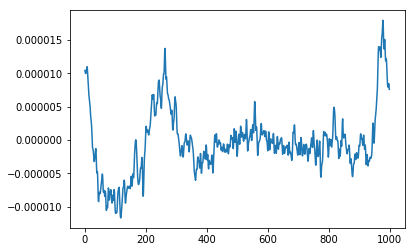

In [128]:
plt.plot(data_1[0][0].T)

In [126]:
chn_14 = reader.readSignal(14)

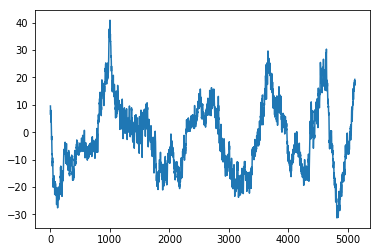

In [131]:
plt.plot(chn_14[256*220:256*240])

## gonna try tfrecords to speed up training

In [2]:
import tensorflow as tf

# Helperfunctions to make your feature definition more readable
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_feature_list(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# Helperfunctions to make your feature definition more readable
def _float_feature_list(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [3]:
trainIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb"))

In [4]:
validIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "rb"))
testIndexDict = pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb"))

In [5]:
for i in trainIndexDict.keys():
    trainIndexDict[i].original_ind = i
for i in validIndexDict.keys():
    trainIndexDict[i].original_ind = i
for i in validIndexDict.keys():
    trainIndexDict[i].original_ind = i

In [6]:
reload(read)
allTrainPatients = read.getAllTrainPatients()

In [7]:
import preprocessingV2.preprocessingV2 as ppv2
def get_data_from_index_datum(index_datum, is_train = True):
    xData = ppv2.get_data_from_start(index_datum.edf_file, index_datum.start)
    yData = index_datum.time_seizure_label
    ySubtypeData = index_datum.time_seizure_subtypes
    split, patient, session, token = read.parse_edf_token_path_structure(index_datum.edf_file)
    montage_data = read.gen_seizure_channel_labels(trainIndexDict[0].edf_file[:-4] + ".lbl", width=pd.Timedelta(seconds=2)).loc[pd.Timedelta(seconds=index_datum.start):pd.Timedelta(seconds=index_datum.start+20)]
    feature = { \
               'original_index': _int64_feature(index_datum.original_ind),
               'data': _float_feature_list(xData.reshape(-1)), \
               'label': _int64_feature_list(yData.to_numpy().reshape(-1)), \
               'subtypeLabel': _int64_feature_list(ySubtypeData.to_numpy().reshape(-1)), \
               'patient': _int64_feature(read.getAllTrainPatients().index(patient) if is_train else 0), \
               'session': _int64_feature(read.getAllTrainSessions().index(session) if is_train else 0)
              }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [104]:
def train_generator(givenRange):
    def give_gen():
        for i in givenRange:
            yield get_data_from_index_datum(trainIndexDict[i]).SerializeToString()
    return give_gen

In [105]:
trainDataset = tf.data.Dataset.from_generator(train_generator(range(0,100)), output_types = (tf.string), 
     output_shapes=(tf.TensorShape([]))) 

In [109]:


j = None
k = None
def save_shard(dataset):

    from pathlib import Path
    Path("/n/scratch2/ms994/medium_size/tfrecord/train").mkdir(parents=True, exist_ok=True)
    def reduce_func(key, data):
        filename = tf.strings.join(["/n/scratch2/ms994/medium_size/tfrecord/train/dataset_", tf.strings.as_string(key)])
        writer = tf.data.experimental.TFRecordWriter(filename)
        writer.write(dataset.map(lambda x: x))
        return tf.data.Dataset.from_tensors(filename)
    NUM_SHARDS = 100
#     dataset = dataset.enumerate()
    def anon(k):
        return 10
    dataset = dataset.apply(tf.data.experimental.group_by_window(
    anon, reduce_func, tf.int64.max
    ))
save_shard(trainDataset)


AttributeError: module 'tensorflow._api.v1.strings' has no attribute 'as_string'

In [95]:
def parse(proto):
    keys_to_features = {'original_index': tf.FixedLenFeature([], tf.int64),\
               'data':  tf.FixedLenFeature([], tf.float32),\
               'label':  tf.FixedLenFeature([], tf.int64),\
               'subtypeLabel':  tf.FixedLenFeature([], tf.int64),\
               'patient':  tf.FixedLenFeature([], tf.int64), \
               'session':  tf.FixedLenFeature([], tf.int64),
                       }
    parsed_features = tf.parse_single_example(proto, keys_to_features)
    return parsedFeatures

In [54]:
dataTest = next(train_generator())

In [99]:
dataTest

(b'\n\xb0\x91\x05\n\x18\n\x05label\x12\x0f\x1a\r\n\x0b\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\n\x1f\n\x0csubtypeLabel\x12\x0f\x1a\r\n\x0b\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\n\xb2\x90\x05\n\x04data\x12\xa8\x90\x05\x12\xa4\x90\x05\n\xa0\x90\x05S]\x196\x7f\xaf\xa16]\xf5b6C?\x015\xa8\nG\xb54\x18\xb7\xb4\xbdS\xf0\xb4s\xaa\xd2\xb5\xa0\x8f\x0c\xb6\x13\xde\xb1\xb5\xe9\x08S\xb5\x81\xf1\xe0\xb5\xf6\x17?\xb6\x96{:\xb6\xca\x8b\x10\xb6\x8f],\xb6\xd3\xb2l\xb6\xaf\x99I\xb6\xfb-d\xb5\t`05\x1b\x0cF4\x1e%Q\xb5\x99b\xe6\xb4\xe7\xa985\xc7\np5\x1fz[3\x8be\x04\xb5\x8c9\x084\x92{\xe15\xf1\x0eq6\xf9\xa2\xab6\'\x9d\xb26\xc8\xd1\x8a6& B6\x82\x9e76\xd9\xbaK6\xcb\xe416\x1b*\x106\xbe\rN6\xa0\x83\xb26\xbf\x8c\xee6^\xc3\xfe6\x12\x80\x017~u\x087\x08\xdb\x077^\xcd\xf26<\xb1\xdc6j?\xe3650\xe26\x93\xb5\xb461\xbdh6\xe7\r%6\xff\xb7\'6n\xaf?6\xff\xe4i6\x88\xef\x9b6P\x81\xbf6\x00R\xc76\xe9\x1a\xc96\xcb\x9b\xe86\xb6G\t7\xf1\xee\t7\x061\xf06\x1f@\xe36W\xe5\x017\x7f\x06\x127`\x9f\x0f7~\xc2\x067\xc1\xd5\x077\xd5e\

In [102]:
example = tf.train.Example()
example.ParseFromString(dataTest[0])

TypeError: a bytes-like object is required, not 'int'

In [101]:
example.

features {
  feature {
    key: "data"
    value {
      float_list {
        value: 2.2853098471387057e-06
        value: 4.8186043386522215e-06
        value: 3.381944452485186e-06
        value: 4.814830276700377e-07
        value: -7.414878382405732e-07
        value: -3.410401632208959e-07
        value: -4.4764411200048926e-07
        value: -1.5695826505179866e-06
        value: -2.0945226424373686e-06
        value: -1.3252159760668292e-06
        value: -7.861659128138854e-07
        value: -1.6759587424530764e-06
        value: -2.847516498150071e-06
        value: -2.778809630399337e-06
        value: -2.153904006263474e-06
        value: -2.5684455522423377e-06
        value: -3.5270829812361626e-06
        value: -3.004078962476342e-06
        value: -8.50035291932727e-07
        value: 6.570485879819898e-07
        value: 1.8444590921262716e-07
        value: -7.791257985445554e-07
        value: -4.2912577669085294e-07
        value: 6.87925819420343e-07
        value: 8

In [17]:
j

In [25]:
reader = tf.data.TFRecordReader("/n/scratch2/ms994/test")

AttributeError: module 'tensorflow._api.v1.data' has no attribute 'TFRecordReader'

In [37]:
dataset =  tf.data.TFRecordDataset(filenames = ["/n/scratch2/ms994/test"])
dataset = dataset.batch(300)
dataTemp = next(iter(dataset))

TensorShape([1])

In [28]:
fsns_test_file

TypeError: 'TFRecordDatasetV1' object is not subscriptable

In [95]:
for i in trainIndexDict.keys():
    writer.write(tf.data.Dataset.from_tensor_slices(get_data_from_index_datum(trainIndexDict[i]).SerializeToString()))

ValueError: Unbatching a tensor is only supported for rank >= 1

# figure out why the network keeps failing to run

In [2]:
from sacred.observers import MongoObserver
import pickle as pkl
from addict import Dict
from sklearn.pipeline import Pipeline
import clinical_text_analysis as cta
import pandas as pd
import numpy as np
import numpy.random as random
from os import path
import data_reader as read
from keras import backend as K

# from multiprocessing import Process
import constants
import util_funcs
import functools
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score, matthews_corrcoef, classification_report, log_loss, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import wf_analysis.datasets as wfdata
from keras_models.dataGen import EdfDataGenerator, DataGenMultipleLabels, RULEdfDataGenerator, RULDataGenMultipleLabels
from keras_models.cnn_models import vp_conv2d, conv2d_gridsearch, inception_like_pre_layers, conv2d_gridsearch_pre_layers
from keras import optimizers
from keras.layers import Dense, TimeDistributed, Input, Reshape, Dropout, LSTM, Flatten, Concatenate, CuDNNLSTM, GaussianNoise, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, TimeDistributed, Dense
import keras.layers as layers
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
import pickle as pkl
import sacred
import keras
import ensembleReader as er
from keras.utils import multi_gpu_model
from keras_models import train
import constants
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras_models.metrics import f1
import random
import string
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.utils import multi_gpu_model
from time import time
from keras_models.homeoschedastic import HomeoschedasticMultiLossLayer, RelativeHomeoschedasticMultiLossLayer
from keras.losses import categorical_crossentropy, binary_crossentropy

from addict import Dict
import preprocessingV2.preprocessingV2 as ppv2

In [3]:
reload(ppv2)
def getCachedData():
    testDR = ppv2.FileDataReader(split="test", directory="/n/scratch2/ms994/medium_size/test", cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/test/20sIndex.pkl", "rb")))
    trainDR = ppv2.RULDataReader(split="train", force_file_sort=False, cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/train/20sIndex.pkl", "rb")))
    validDR = ppv2.FileDataReader(split="valid", directory="/n/scratch2/ms994/medium_size/valid", cachedIndex=pkl.load(open("/n/scratch2/ms994/medium_size/valid/20sIndex.pkl", "rb")))
    return trainDR, validDR, testDR
def get_dg(batch_size=16):
    train, valid, test = getCachedData()
    return EdfDataGenerator(train, precache=False, batch_size=batch_size, n_classes=2, shuffle=False), EdfDataGenerator(valid, precache=False, batch_size=batch_size, n_classes=2, shuffle=False), EdfDataGenerator(test, precache=False, batch_size=batch_size, n_classes=2, shuffle=False)


## grab and create a model

In [4]:
input = Input((11,21,1000,1))
x = GaussianNoise(4)(input)
for i in range(3):
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(4, (3,3), activation="relu"))(x)
    x = TimeDistributed(MaxPool2D((1,2)))(x)
for i in range(3):
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(8, (3,3), activation="relu"))(x)
    x = TimeDistributed(MaxPool2D((1,2)))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, activation="relu", return_sequences=True)(x)
x = TimeDistributed(Dense(64, activation="relu"))(x)
x = TimeDistributed(Dropout(0.5))(x)

y = TimeDistributed(Dense(2, activation="relu"))(x)
model = Model(inputs=[input], outputs=[y])
model.compile(keras.optimizers.Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["binary_accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11, 21, 1000, 1)   0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 11, 21, 1000, 1)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 21, 1000, 1)   4         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 19, 998, 4)    40        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 19, 499, 4)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 19, 499, 4)    16        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 11, 17, 497, 4)    148       
__________

In [6]:
reload(ppv2)
train, valid, test = get_dg()

In [7]:
ppv2._get_pickle_data_lru_cache.cache_info()

CacheInfo(hits=0, misses=0, maxsize=20, currsize=0)

In [19]:
miniTrain = train[0]

In [30]:
data = train[1]

In [16]:
data[0].shape

(16, 11, 21, 1000, 1)

In [65]:
len(train)

575

In [77]:
import os

In [97]:
data_paths = os.listdir("/n/scratch2/ms994/medium_size/train")

In [98]:
data_paths.remove("seizure_only")
data_paths.remove("non_seizure_only")
data_paths.remove("20sIndex.pkl")
data_paths.remove("20sindex.pkl")

In [99]:
dp = []
for datapath in data_paths:
    dp += ["/n/scratch2/ms994/medium_size/train/" + datapath +"/" + ret for ret in os.listdir("/n/scratch2/ms994/medium_size/train/" + datapath)]

In [100]:
datapaths = dp
dp = []
for datapath in datapaths:
    dp += [datapath + "/" + dp for dp in os.listdir(datapath)]

In [102]:
datapaths = dp
dp = []
for datapath in datapaths:
    dp += [datapath + "/" + dp for dp in os.listdir(datapath)]

In [110]:
badIntermediates = []
for datapath in dp:
    if not datapath[-4:] == (".tse") and not datapath[-4:] == (".txt") and not datapath[-4:] ==  (".lbl"):
        if os.path.getsize(datapath) < 1000:
            badIntermediates.append(datapath)
# os.path.getsize(dp[0])

In [111]:
badIntermediates

[]

In [15]:
train.batch_size

16

In [24]:
train.dataset.indexDict[1504].edf_file

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/00008476_s003_t011.edf'

In [30]:
train.dataset.indexDict[48291].start

740

In [31]:
train.dataset[1504]

KeyError: 370.0

In [33]:
data = ppv2.get_pickle_data(train.dataset.indexDict[48291].edf_file, 300, "train")

In [35]:
ppv2.get_edf_pickle_name(train.dataset.indexDict[48291].edf_file, 300, "train")

'/n/scratch2/ms994/medium_size/train/00010450/s001_2013_06_19/00010450_s001_t001.edf/intermediate_1'

In [37]:
%%bash
ls -lah /n/scratch2/ms994/medium_size/train/00010450/s001_2013_06_19/00010450_s001_t001.edf/

total 28K
drwxrwxr-x 2 ms994 ms994 4.0K Mar  3 00:22 .
drwxrwxr-x 4 ms994 ms994 4.0K Mar  3 00:21 ..
-rw-rw-r-- 1 ms994 ms994   32 Mar  3 00:22 intermediate_1
-rw-rw-r-- 1 ms994 ms994   51 Mar  3 00:21 label.tse
-rw-rw-r-- 1 ms994 ms994 5.3K Mar  3 00:21 montage.lbl
-rw-rw-r-- 1 ms994 ms994 2.0K Mar  3 00:21 notes.txt


In [67]:
from pathlib import Path
import mne, pickle
import shutil
def run_prep(file_name, annotation, split="train"):
        data = mne.io.read_raw_edf(file_name, preload=True)
        data = data.pick_channels(util_funcs.get_common_channel_names())
        data = data.reorder_channels(util_funcs.get_common_channel_names())
        data.rename_channels(constants.MNE_CHANNEL_EDF_MAPPING)
        data.resample(512) #upsample to highest frequency, as per best practice
        data.set_eeg_reference()

        data.set_montage("standard_1020")
        data.filter(1, 50)

        montage_kind = "standard_1020"
        maxTime = annotation.index.max()/pd.Timedelta(seconds=1)
        montage = mne.channels.make_standard_montage(montage_kind)
        ref, patient, session, token = read.parse_edf_token_path_structure(file_name)

        # for i in range(int(maxTime/2)):
        basePath = f"/n/scratch2/ms994/medium_size/{split}/{patient}/{session}/{token}/"
        Path(basePath).mkdir( parents=True, exist_ok=True)


        shutil.copyfile(file_name[:-4]+".tse", f"{basePath}label.tse")
        shutil.copyfile(file_name[:-4]+".lbl", f"{basePath}montage.lbl")
        shutil.copyfile(file_name[:-9]+".txt", f"{basePath}notes.txt")

        dataDict = Dict()

        for i in range(int(maxTime/2) - 1):
            croppedData = data.copy().crop(i*2, i*2 + 4)
            croppedData.resample(constants.COMMON_FREQ) #resample to minimum
            dataDict[i].index = i
            dataDict[i].data = croppedData
            dataDict[i].start = i*2
            dataDict[i].end = i*2 + 4
            if (i % 500 == 499): # save up to 500 separate data segments at a time to avoid IO bottleneck in scratch2, but also to avoid creating any pickle that is too big to parse_edf_token_path_structure
                pickle.dump(dataDict, open(basePath+f"intermediate_{int(np.ceil(i/500))}", "wb"))
                dataDict = Dict()
        pickle.dump(dataDict, open(basePath+f"intermediate_{int(np.ceil(i/500))}", "wb"))
        print(f"COMPLETED {file_name}")
run_prep("/home/ms994/v1.5.0/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/00010450_s001_t001.edf", trainValidPairs[739][1])

Extracting EDF parameters from /home/ms994/v1.5.0/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/00010450_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 257279  =      0.000 ...  1004.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'PO4', 'FC3', 'FC1', 'P6', 'FC5', 'PO7', 'F5', 'F6', 'AF8', 'P5', 'PO1', 'AF6', 'M2', 'FT10', 'T8', 'TP7', 'P8', 'FCz', 'TP9', 'AF1', 'F2', 'AF10', 'T7', 'C2', 'TP8', 'Iz', 'T10', 'PO5', 'PO2', 'C6', 'PO8', 'FC4', 'AF5', 'AF4', 'PO6', 'C1', 'AF7', 'AF9', 'FC2', 'CP2', 'AF3', 'P7', 'P10', 'F1', 'FT8', 'PO10', 'F9', 'CP6', 'FC6', 'Oz', 'CPz', 'TP10', 'CP4', 'P9', 'T9', 'FT9', 'P2', 'CP1', 'O9', 'PO9', 'AFz', 'AF2', 'CP3', 'M1', 'Fpz', 'PO3', 'O10', 'POz', 'FT7', 'C5', 'CP5', 'P1', 'F10'}
Filtering raw data in 1 contiguous segment


In [55]:
%%bash
ls /home/ms994/v1.5.0/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19

00010450_s001.txt
00010450_s001_t000.edf
00010450_s001_t000.lbl
00010450_s001_t000.lbl_bi
00010450_s001_t000.tse
00010450_s001_t000.tse_bi
00010450_s001_t001.edf
00010450_s001_t001.lbl
00010450_s001_t001.lbl_bi
00010450_s001_t001.tse
00010450_s001_t001.tse_bi


In [56]:
trainValidPairs[0][0]

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf'

In [57]:
[train_label_files_seg[0] for train_label_files_seg in trainValidPairs].index("/home/ms994/v1.5.0/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/00010450_s001_t001.edf")

739

In [ ]:
annotations = read.

In [ ]:
self.indexes

In [12]:
model.fit_generator( \
                        train, \
                        validation_data=valid, \
                        epochs=100, \
                        workers=8, \
                        max_queue_size=30, \
                        use_multiprocessing=True, \
                        callbacks=[ \
                                   keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr*0.9, verbose=1), \
                                   keras.callbacks.EarlyStopping(patience=20), \
                                   keras.callbacks.ModelCheckpoint("bestModel.h5", save_best_only=True), \
                                   ])

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 8.100000122794882e-05.
  9/575 [..............................] - ETA: 24:29 - loss: 1.2287 - binary_accuracy: 0.1985

OSError: [Errno 12] Cannot allocate memory

In [11]:
ppv2._get_pickle_data_lru_cache.cache_info()

CacheInfo(hits=0, misses=0, maxsize=20, currsize=0)